In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D ,LSTM ,RepeatVector,TimeDistributed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DATA/Normal_data.csv')
df.head(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,...,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,185.127.17.56-192.168.20.133-443-53648-6,185.127.17.56,443,192.168.20.133,53648,6,5/2/2020 13:58,245230,44,40,124937.0,1071.0,9100,0,2839.477273,1839.508257,517,0,26.775000,109.188026,513835.99070,342.535579,2954.578313,7953.221927,64066.0,-44.0,238564.0,5548.000000,10446.29576,64066.0,2.0,245230.0,6287.948718,12986.46879,79070.0,29.0,0,0,0,0,...,0,9100,1482.447059,1933.268313,3.737526e+06,0,1,0,0,1,0,0,0,0,1500.095238,2839.477273,26.775000,0,0,0,0,0,0,44,124937,40,1071,-1,65535,41,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,185.127.17.56-192.168.20.133-443-53650-6,192.168.20.133,53650,185.127.17.56,443,6,5/2/2020 13:58,1605449,107,149,1071.0,439537.0,517,0,10.009346,67.496680,27300,0,2949.912752,3012.589539,274445.34210,159.456949,6295.878431,56408.330520,859760.0,-102.0,1332121.0,12567.179250,83434.14155,861138.0,2.0,1603130.0,10831.959460,73926.65245,861129.0,1.0,0,0,0,0,...,0,27300,1714.428016,2713.465917,7.362897e+06,0,1,0,0,0,0,0,0,1,1721.125000,10.009346,2949.912752,0,0,0,0,0,0,107,1071,149,439537,-1,64240,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.133,35108,192.168.20.2,53,6,5/2/2020 13:58,53078,5,5,66.0,758.0,66,0,13.200000,29.516097,638,0,151.600000,276.826299,15524.32269,188.401974,5897.555556,15184.845200,46232.0,19.0,50302.0,12575.500000,22521.87727,46251.0,67.0,52962.0,13240.500000,22052.04405,46258.0,405.0,0,0,0,0,...,0,638,74.909091,190.807471,3.640749e+04,0,1,0,0,0,0,0,0,1,82.400000,13.200000,151.600000,0,0,0,0,0,0,5,66,5,758,-1,64240,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.2,53,192.168.20.133,35108,6,5/2/2020 13:58,6975,1,1,0.0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.00000,286.738351,6975.000000,0.000000,6975.0,6975.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0,0,0,0,...,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,-1,64239,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,154.59.122.74-192.168.20.133-443-60900-6,192.168.20.133,60900,154.59.122.74,443,6,5/2/2020 13:58,190141,13,16,780.0,11085.0,427,0,60.000000,130.042942,2596,0,692.812500,794.157350,62401.06027,152.518394,6790.750000,12933.295910,38521.0,-54.0,86882.0,7240.166667,13050.84163,38805.0,1.0,190141.0,12676.066670,15949.09279,38521.0,1.0,0,0,0,0,...,0,2596,395.500000,661.691706,4.378359e+05,0,1,0,0,0,0,0,0,1,409.137931,60.000000,692.812500,0,0,0,0,0,0,13,780,16,11085,-1,64240,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [ ]:
df.isna().sum()

Flow ID      0
Src IP       0
Src Port     0
Dst IP       0
Dst Port     0
            ..
Idle Mean    0
Idle Std     0
Idle Max     0
Idle Min     0
Label        0
Length: 84, dtype: int64

In [ ]:
print("Type:\n",type(df))
print("Information about the dataframe:\n",df.info)
print("Shape of the dataframe :\n",df.shape)
df.drop_duplicates()
print(df.shape)
print("Columns of the dataframe:\n",df.columns)

Type:
 <class 'pandas.core.frame.DataFrame'>
Information about the dataframe:
 <bound method DataFrame.info of                                         Flow ID  ...   Label
0      185.127.17.56-192.168.20.133-443-53648-6  ...  Normal
1      185.127.17.56-192.168.20.133-443-53650-6  ...  Normal
2        192.168.20.133-192.168.20.2-35108-53-6  ...  Normal
3        192.168.20.133-192.168.20.2-35108-53-6  ...  Normal
4      154.59.122.74-192.168.20.133-443-60900-6  ...  Normal
...                                         ...  ...     ...
68419  185.127.17.56-192.168.20.133-443-36100-6  ...  Normal
68420   192.168.20.133-192.168.20.2-53032-53-17  ...  Normal
68421   192.168.20.133-192.168.20.2-39285-53-17  ...  Normal
68422   192.168.20.133-192.168.20.2-49895-53-17  ...  Normal
68423   192.168.20.133-192.168.20.2-33786-53-17  ...  Normal

[68424 rows x 84 columns]>
Shape of the dataframe :
 (68424, 84)
(68424, 84)
Columns of the dataframe:
 Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'D

In [ ]:
df.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max     float64
Idle Min     float64
Label         object
Length: 84, dtype: object

In [ ]:
num_cols = df._get_numeric_data().columns

cate_cols = list(set(df.columns)-set(num_cols))

cate_cols

['Timestamp', 'Dst IP', 'Flow ID', 'Label', 'Src IP']

In [ ]:
df.drop(['Flow ID', 'Src IP' ,'Dst IP' ,'Timestamp','Src Port','Dst Port','Protocol'], inplace=True,axis = 1)
df.shape


(68424, 77)

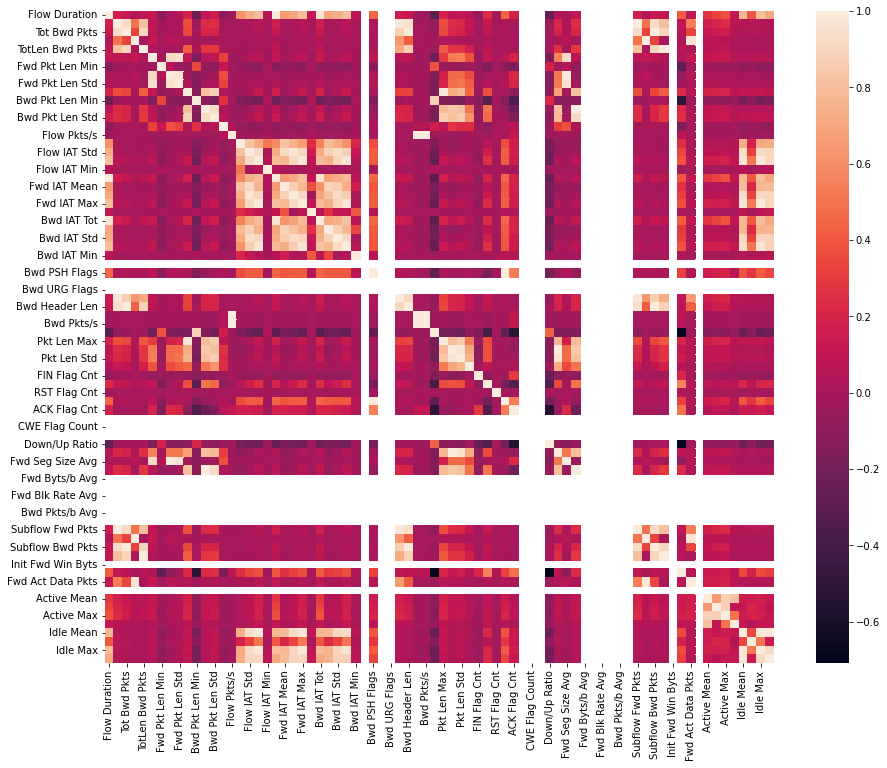

In [ ]:

df = df.dropna('columns')# drop columns with NaN

#df = df[[col for col in df if df[col].nunique() > 1]]# keep columns where there are more than 1 unique values

corr = df.corr()

plt.figure(figsize=(15,12))

sns.heatmap(corr)

plt.show()

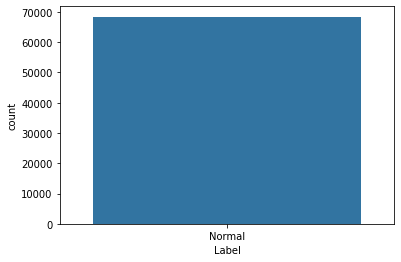

In [ ]:

ax = sns.countplot(x="Label", data=df)

In [ ]:
#Encoding categorical data i.e Label
pmap = {'Normal':0,'Probe ':1,'DDoS':1,'DoS':1,'BFA':1,'Web-Attack':1,'BOTNET':1,'U2R':1,'DDoS':1}
df['Label'] = df['Label'].map(pmap)


In [ ]:
print("Shape after removal of socket information and columns having unique value <=1 :\n",df.shape)
df.columns

Shape after removal of socket information and columns having unique value <=1 :
 (68424, 77)


Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
   

In [ ]:
df['Label'].value_counts()

0    68424
Name: Label, dtype: int64

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
df=clean_dataset(df)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
min_col = {}
max_col = {}
balance = {}
for col in df:
    max_col[col]= df[col].max()
    min_col[col]= df[col].min()
    #plt.hist(df[col])
    #plt.show()
    balance[col]= max_col[col] + min_col[col]

result = pd.DataFrame([min_col, max_col, balance], index=['min', 'max', 'balance'])
print(result)    

         Flow Duration  Tot Fwd Pkts  ...     Idle Min  Label
min             -154.0           0.0  ...          0.0    0.0
max        119999993.0       16928.0  ...  119000000.0    0.0
balance    119999839.0       16928.0  ...  119000000.0    0.0

[3 rows x 77 columns]


In [ ]:
# Target variable and train set
Y = df[['Label']]
X = df.drop(['Label',], axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)


In [ ]:
print(X)
print(Y)

[[2.04486416e-03 2.59924386e-03 1.14392984e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.33800086e-02 6.32088847e-03 4.34106708e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.43599457e-04 2.95368620e-04 1.17326137e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.23749603e-05 5.90737240e-05 5.86630687e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.72874788e-04 0.00000000e+00 2.93315343e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.66083007e-05 5.90737240e-05 5.86630687e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
       Label
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
...      ...
68419    0.0
68420    0.0
68421    0.0
68422    0.0
68423    0.0

[68424 rows x 1 columns]


In [ ]:
#splitting up data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(45844, 76) (22580, 76)
(45844, 1) (22580, 1)


In [ ]:
# reshaping the data for model
X_train_shape = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train_shape.shape)
X_test_shape = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test_shape.shape)

Training data shape: (45844, 1, 76)
Test data shape: (22580, 1, 76)


In [ ]:
print(np.any(np.isnan(X_train_shape)))
print(np.all(np.isfinite(X_train_shape)))

False
True


In [ ]:
model = Sequential()
# Encoder
model.add(LSTM(128, activation='tanh', input_shape=(X_train_shape.shape[1], X_train_shape.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(32,activation='tanh', return_sequences=True))
model.add(LSTM(16,activation='tanh', return_sequences=False))
model.add(RepeatVector(X_train.shape[1]))
# Decoder
model.add(LSTM(16, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(X_train_shape.shape[2])))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            104960    
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 76, 16)           0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 76, 16)            2112      
                                                        

In [ ]:
#nb_epochs = 100
nb_epochs=30
batch_size = 32
history = model.fit(X_train_shape, X_train_shape, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/30
1361/1361 [==============================] - 262s 183ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 2/30
1361/1361 [==============================] - 248s 182ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/30
1361/1361 [==============================] - 247s 182ms/step - loss: 8.6838e-04 - val_loss: 6.5215e-04
Epoch 4/30
1361/1361 [==============================] - 248s 182ms/step - loss: 8.0662e-04 - val_loss: 5.5365e-04
Epoch 5/30
1361/1361 [==============================] - 246s 180ms/step - loss: 4.3009e-04 - val_loss: 4.4001e-04
Epoch 6/30
1361/1361 [==============================] - 244s 179ms/step - loss: 3.7144e-04 - val_loss: 3.7557e-04
Epoch 7/30
1361/1361 [==============================] - 243s 178ms/step - loss: 5.0901e-04 - val_loss: 3.9427e-04
Epoch 8/30
1361/1361 [==============================] - 242s 178ms/step - loss: 3.1441e-04 - val_loss: 3.5392e-04
Epoch 9/30
1361/1361 [==============================] - 244s 179ms/step - loss: 4.1864e-04 - val_loss: 3

In [ ]:
model.save("my_model.h5")

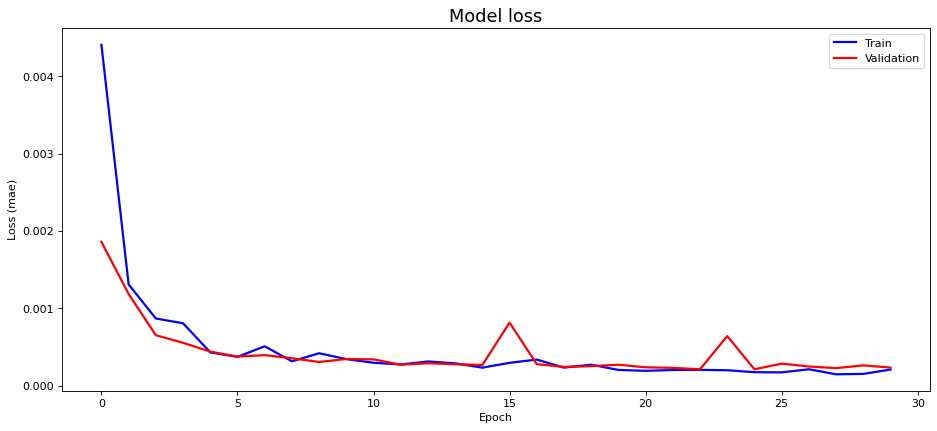

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
predict=model.predict(X_train_shape)

In [ ]:
mse = np.mean(np.power(X_train_shape - predict, 2), axis=1)
print(mse)

[[6.75388510e-05 6.81645431e-07 3.70831265e-07 ... 1.01961768e-05
  4.28173925e-05 4.39588047e-06]
 [6.17717326e-06 1.38977198e-07 1.14322516e-07 ... 1.14221637e-07
  7.59210957e-07 4.12206436e-07]
 [5.31929600e-06 1.52503171e-07 1.23605124e-07 ... 1.15693828e-07
  5.32012079e-07 4.57005319e-07]
 ...
 [6.08647222e-06 1.38577239e-07 1.12986582e-07 ... 1.14891976e-07
  7.32699031e-07 3.86363505e-07]
 [4.22560785e-04 6.59725861e-06 1.02460810e-05 ... 3.71951126e-04
  2.09913704e-04 2.99271976e-05]
 [6.61242738e-05 1.10652453e-06 3.54496877e-07 ... 2.24849971e-06
  1.91024944e-05 8.41359327e-06]]


Reconstruction error threshold: 1.0038900579276837


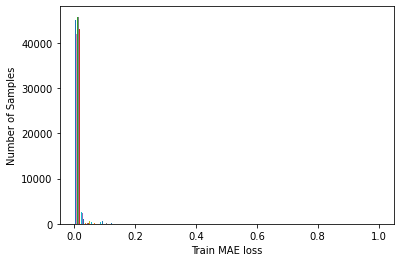

In [ ]:
X_train_pred = model.predict(X_train_shape, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_shape), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 1.0085564741962834


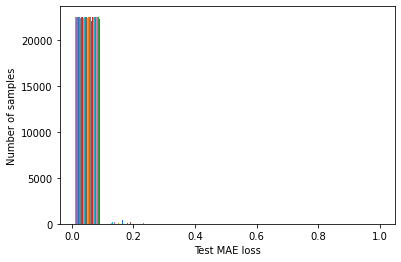

In [ ]:
X_test_pred = model.predict(X_test_shape, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test_shape), axis=1)

plt.hist(test_mae_loss)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
threshold = np.max(test_mae_loss)

print(f'Reconstruction error threshold: {threshold}')
#model.evaluate(X_train_shape, predict)


In [ ]:
#train_x_predictions = model.predict(X_train)
mse = np.mean(np.power(X_train_shape - predict, 2), axis=1)
print(mse)

[[3.11265906e-04 6.64139494e-07 1.92760286e-06 ... 7.35241910e-06
  7.11615747e-06 1.50508178e-05]
 [2.57041157e-05 1.04920136e-06 1.56169826e-06 ... 3.40049610e-06
  2.48611529e-05 8.01727433e-06]
 [2.58030053e-05 1.04919533e-06 1.56163237e-06 ... 3.40084702e-06
  2.48603618e-05 8.01634799e-06]
 ...
 [2.56997044e-05 1.04919623e-06 1.56217368e-06 ... 3.39680950e-06
  2.48577628e-05 8.01608405e-06]
 [1.45239419e-03 1.46937144e-07 1.72508423e-06 ... 8.94116738e-05
  1.75878984e-04 1.74778850e-05]
 [7.32360424e-05 5.47055244e-07 1.52351106e-06 ... 1.26175501e-05
  3.40948293e-05 1.97650024e-05]]


ONE-CLASS SVM TRAINED ON OUTPUT FEATURE VECTOR

In [ ]:
nsamples, nx, ny = X_train_pred.shape
d2_train_dataset = X_train_pred.reshape((nsamples,nx*ny))

In [ ]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.4, kernel="rbf", gamma=0.001)
clf.fit(d2_train_dataset)

In [ ]:
test_data=pd.read_csv('/content/drive/MyDrive/DATA/file.csv')
test_data.head()

In [ ]:
test_data.drop(['Flow ID', 'Src IP' ,'Dst IP' ,'Timestamp','Src Port','Dst Port','Protocol'], inplace=True,axis = 1)
test_data.shape

## RECONSTRUCTION ERROR

In [ ]:
df_ano=pd.read_csv('/content/drive/MyDrive/DATA/metasploitable-2.csv')
df_ano.head(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,...,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.3.130-200.175.2.130-38694-4444-6,192.168.3.130,38694,200.175.2.130,4444,6,10/1/2020 5:02,269709,4,5,48,23,30,0,12.0,14.696938,23,0,4.600000,10.285913,263.246684,33.369298,33713.625000,90272.549880,257068.0,14.0,260808.0,86936.0,149854.765700,259973.0,104.0,269709.0,67427.250000,126912.740800,257785.0,2956,0,0,0,0,...,0,30,7.100000,11.779926,138.766667,0,1,0,0,0,0,0,0,1,7.888889,12.0,4.600000,0,0,0,0,0,0,4,48,5,23,-1,64,2,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
1,192.168.3.130-200.175.2.130-38693-4444-6,192.168.3.130,38693,200.175.2.130,4444,6,10/1/2020 5:02,268599,2,3,0,23,0,0,0.0,0.000000,23,0,7.666667,13.279056,85.629507,18.615110,67149.750000,132430.553600,265786.0,11.0,265811.0,265811.0,0.000000,265811.0,265811.0,268574.0,134287.000000,185983.225600,265797.0,2777,0,0,0,0,...,0,23,3.833333,9.389711,88.166667,0,1,0,0,0,0,0,0,1,4.600000,0.0,7.666667,0,0,0,0,0,0,2,0,3,23,-1,64,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
2,192.168.3.130-200.175.2.130-3632-33747-6,200.175.2.130,33747,192.168.3.130,3632,6,10/1/2020 5:02,22194,5,5,53,30,30,0,10.6,14.724130,30,0,6.000000,13.416408,3739.749482,450.572227,2466.000000,2951.053583,8063.0,3.0,17518.0,4379.5,6184.320254,13537.0,3.0,15128.0,3782.000000,3420.925898,8063.0,42,0,0,0,0,...,0,30,7.545455,13.048859,170.272727,0,1,0,0,0,0,0,0,1,8.300000,10.6,6.000000,0,0,0,0,0,0,5,53,5,30,-1,215,2,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
3,192.168.3.130-200.175.2.130-8180-38745-6,200.175.2.130,38745,192.168.3.130,8180,6,10/1/2020 1:39,9556,4,4,30,30,30,0,7.5,15.000000,30,0,7.500000,15.000000,6278.777731,837.170364,1365.142857,1447.714225,4022.0,13.0,5511.0,1837.0,1441.824885,3380.0,524.0,5588.0,1862.666667,2386.259067,4559.0,23,0,0,0,0,...,0,30,6.666667,13.228757,175.000000,0,1,0,0,0,0,0,0,1,7.500000,7.5,7.500000,0,0,0,0,0,0,4,30,4,30,-1,215,1,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BFA
4,192.168.3.130-200.175.2.130-8180-37217-6,200.175.2.130,37217,192.168.3.130,8180,6,10/1/2020 1:39,8782,4,4,30,30,30,0,7.5,15.000000,30,0,7.500000,15.000000,6832.156684,910.954225,1254.571429,1607.096435,4049.0,8.0,4725.0,1575.0,2277.042160,4204.0,226.0,5618.0,1872.666667,2191.816674,4287.0,8,0,0,0,0,...,0,30,6.666667,13.228757,175.000000,0,1,0,0,0,0,0,0,1,7.500000,7.5,7.500000,0,0,0,0,0,0,4,30,4,30,-1,215,1,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BFA


In [ ]:
df_ano.drop(['Flow ID', 'Src IP' ,'Dst IP' ,'Timestamp','Src Port','Dst Port','Protocol'], inplace=True,axis = 1)
df_ano.shape

(136743, 77)

In [ ]:

#df_ano = df.dropna('columns')

In [ ]:
df_ano.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
   

In [ ]:
df_ano['Label'].value_counts()

DDoS     73529
Probe    61757
DoS       1145
BFA        295
U2R         17
Name: Label, dtype: int64

In [ ]:
#Encoding categorical data i.e Label
pmap = {'Normal':0,'Probe ':1,'DDoS':1,'DoS':1,'BFA':1,'Web-Attack':1,'BOTNET':1,'U2R':1,'DDoS':1}
df_ano['Label'] = df_ano['Label'].map(pmap)


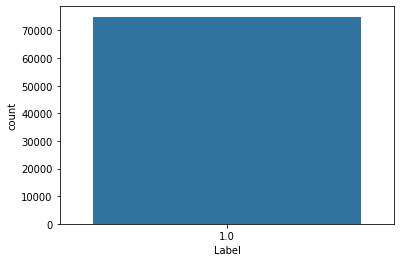

In [ ]:
bx = sns.countplot(x="Label", data=df_ano)

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
df_ano=clean_dataset(df_ano)

In [ ]:
df_ano.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,269709.0,4.0,5.0,48.0,23.0,30.0,0.0,12.0,14.696938,23.0,0.0,4.600000,10.285913,263.246684,33.369298,33713.625000,90272.549880,257068.0,14.0,260808.0,86936.0,149854.765700,259973.0,104.0,269709.0,67427.250000,126912.740800,257785.0,2956.0,0.0,0.0,0.0,0.0,128.0,176.0,14.830799,18.538499,0.0,30.0,7.100000,11.779926,138.766667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.888889,12.0,4.600000,0.0,0.0,0.0,0.0,0.0,0.0,4.0,48.0,5.0,23.0,-1.0,64.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,268599.0,2.0,3.0,0.0,23.0,0.0,0.0,0.0,0.000000,23.0,0.0,7.666667,13.279056,85.629507,18.615110,67149.750000,132430.553600,265786.0,11.0,265811.0,265811.0,0.000000,265811.0,265811.0,268574.0,134287.000000,185983.225600,265797.0,2777.0,0.0,0.0,0.0,0.0,64.0,112.0,7.446044,11.169066,0.0,23.0,3.833333,9.389711,88.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.600000,0.0,7.666667,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,23.0,-1.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,22194.0,5.0,5.0,53.0,30.0,30.0,0.0,10.6,14.724130,30.0,0.0,6.000000,13.416408,3739.749482,450.572227,2466.000000,2951.053583,8063.0,3.0,17518.0,4379.5,6184.320254,13537.0,3.0,15128.0,3782.000000,3420.925898,8063.0,42.0,0.0,0.0,0.0,0.0,160.0,176.0,225.286113,225.286113,0.0,30.0,7.545455,13.048859,170.272727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.300000,10.6,6.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.0,53.0,5.0,30.0,-1.0,215.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,9556.0,4.0,4.0,30.0,30.0,30.0,0.0,7.5,15.000000,30.0,0.0,7.500000,15.000000,6278.777731,837.170364,1365.142857,1447.714225,4022.0,13.0,5511.0,1837.0,1441.824885,3380.0,524.0,5588.0,1862.666667,2386.259067,4559.0,23.0,0.0,0.0,0.0,0.0,128.0,144.0,418.585182,418.585182,0.0,30.0,6.666667,13.228757,175.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.500000,7.5,7.500000,0.0,0.0,0.0,0.0,0.0,0.0,4.0,30.0,4.0,30.0,-1.0,215.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8782.0,4.0,4.0,30.0,30.0,30.0,0.0,7.5,15.000000,30.0,0.0,7.500000,15.000000,6832.156684,910.954225,1254.571429,1607.096435,4049.0,8.0,4725.0,1575.0,2277.042160,4204.0,226.0,5618.0,1872.666667,2191.816674,4287.0,8.0,0.0,0.0,0.0,0.0,128.0,144.0,455.477112,455.477112,0.0,30.0,6.666667,13.228757,175.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.500000,7.5,7.500000,0.0,0.0,0.0,0.0,0.0,0.0,4.0,30.0,4.0,30.0,-1.0,215.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
Y_ano = df_ano[['Label']]
X_ano = df_ano.drop(['Label',], axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
X_ano = sc.fit_transform(X_ano)


In [ ]:
X_train_ano, X_test_ano, Y_train_ano, Y_test_ano = train_test_split(X_ano, Y_ano, test_size=0.33, random_state=42)
print(X_train_ano.shape, X_test_ano.shape)
print(Y_train_ano.shape, Y_test_ano.shape)

(50240, 76) (24746, 76)
(50240, 1) (24746, 1)


In [ ]:
# reshaping the data for model
X_valid = X_test_ano.reshape(X_test_ano.shape[0], 1, X_test_ano.shape[1])
print("Anomaly data shape:", X_valid.shape)


Anomaly data shape: (24746, 1, 76)


In [ ]:
X_ano_pred = model.predict(X_valid, verbose=0)
X_ano_pred.shape
# train_mae_loss = np.mean(np.abs(X_ano_pred - X_train_shape), axis=1)
anomaly_mae_loss = np.mean(np.abs(X_ano_pred-X_valid), axis=1)

# plt.hist(train_mae_loss)
# plt.xlabel('Train MAE loss')
# plt.ylabel('Number of Samples');

# threshold = np.max(train_mae_loss)
# print(f'Reconstruction error threshold: {threshold}')

In [ ]:
anomaly_threshold = np.max(anomaly_mae_loss)
print(anomaly_threshold)

1.011212216200013


In [ ]:
conf_matrix = confusion_matrix(True_class,X_ano_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()